# About Dataset
link https://www.kaggle.com/datasets/tawsifurrahman/covid19-complete-blood-count-clinical-database?select=COVID-19_CBC_Data.csv

## COVID-19 Complete Blood Count (CBC) Database
A team of researchers and doctors from Qatar University, Doha, Qatar, and Dhaka Medical College Hospital, Bangladesh, have created a database of complete blood count, demographic data, and corresponding patients' outcome. The data was collected between 12 April and 31 August 2020 at Dhaka Medical College Hospital, Bangladesh which is approved by the Hospital Ethical Committee. Clinical parameters with hospital admission, discharge/death outcomes were collected for 103 patients (Survived-61 (59.22%), Death-42 (40.78%)).

Credit should go to the following:
-Tawsifur Rahman1, Amith Khandakar1, Md Enamul Hoque2, Nabil Ibtehaz3, Saad Bin Kashem4, Reehum Masud5, Lutfunnahar Shampa6, Mohammad Mehedi Hasan7, Mohammad T. Islam8, Somaya Al-Madeed9, Susu M. Zughaier10, Saif Badran11,12, Suhail A. R. Doi12, Muhammad E. H. Chowdhury1*

1Department of Electrical Engineering, Qatar University, Doha 2713, Qatar 2Department of Biomedical Engineering, Military Institute of Science and Technology, Dhaka 1216, Bangladesh 3Department of Computer Science and Engineering, Bangladesh, University of Engineering and Technology, Dhaka-1205, Bangladesh 4Faculty of Robotics and Advanced Computing, Qatar Armed Forces‐Academic Bridge Program, Qatar Foundation, Doha 24404, Qatar 5Department - COVID Isolation Unit, United Hospital Limited, Dhaka 1212, Bangladesh 6Department of Obstetrics and Gynecology, Dhaka Medical College Hospital (COVID UNIT), Dhaka 1000, Bangladesh 7Dhaka North City Corporation COVID Hospital, Dhaka 1208, Bangladesh 8Dept. of Electrical, Electronics and Systems Engineering, Universiti Kebangsaan Malaysia, Bangi, Selangor 43600, Malaysia 9Department of Computer Science and Engineering, Qatar University, Doha 2713, Qatar
10Department of Basic Medical Sciences, College of Medicine, QU Health, Qatar University, Doha 2713, Qatar 11Department of Plastic Surgery, Hamad Medical Corporation, Doha, Qatar. 12Department of Population Medicine, College of Medicine, QU Health, Qatar University, Doha 2713, Qatar

Objective
Researchers can use this database to produce useful and impactful scholarly work on COVID-19, which can help in tackling this issue.

Citation
Please cite this database if you are using it for any scientific purpose.

## Imports

In [4]:
import pandas as pd
import os
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression

## Data Loading And Preprocessing

In [5]:
def preprocess_dates(df):
    # Convert date columns to datetime objects, coercing errors
    df['Admission_DATE'] = pd.to_datetime(df['Admission_DATE'], errors='coerce')
    df['Sample Collection Date'] = pd.to_datetime(df['Sample Collection Date'], errors='coerce')

    # Feature Engineering from Admission_DATE
    df['Admission_Year'] = df['Admission_DATE'].dt.year
    df['Admission_Month'] = df['Admission_DATE'].dt.month
    df['Admission_Day'] = df['Admission_DATE'].dt.day
    df['Admission_DayOfWeek'] = df['Admission_DATE'].dt.dayofweek  # Monday=0, Sunday=6

    # Cyclic features for month to capture seasonality
    df['Admission_Month_sin'] = np.sin(2 * np.pi * df['Admission_Month'] / 12)
    df['Admission_Month_cos'] = np.cos(2 * np.pi * df['Admission_Month'] / 12)

    # Is Weekend Admission?
    df['Is_Weekend_Admission'] = df['Admission_DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # Time Difference between Admission and Sample Collection
    df['Time_to_Sample_days'] = (df['Sample Collection Date'] - df['Admission_DATE']).dt.days

    # Is Sample Collection on the same day as Admission?
    df['Is_Same_Day_Sample'] = (df['Time_to_Sample_days'] == 0).astype(int)

    # Convert original datetime columns to Unix timestamp for numerical analysis
    # Handle NaT values by coercing to NaN and then filling with -1, then converting to int
    df['Admission_Timestamp'] = (df['Admission_DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    df['Admission_Timestamp'] = df['Admission_Timestamp'].fillna(-1).astype(int)

    df['Sample_Collection_Timestamp'] = (df['Sample Collection Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    df['Sample_Collection_Timestamp'] = df['Sample_Collection_Timestamp'].fillna(-1).astype(int)

    # Drop original date columns as their features have been extracted
    df = df.drop(columns=['Admission_DATE', 'Sample Collection Date'])

    return df

print("The 'preprocess_dates' function has been defined.")

The 'preprocess_dates' function has been defined.


In [6]:
path = kagglehub.dataset_download("tawsifurrahman/covid19-complete-blood-count-clinical-database")
df = pd.read_csv(os.path.join(path,'COVID-19_CBC_Data.csv'))
df = df.drop('Discharge_DATE or date of Death',axis=1)
df['What kind of Treatment provided '] = df['What kind of Treatment provided '].str.strip()
df['Outcome'] = df['Outcome'].apply(lambda x:1 if x == 'Not Recovered' else 0)
df['Gender'] = df['Gender'].apply(lambda x:1 if x == 'Male' else 0)
df['Ventilated (Y/N)'] = df['Ventilated (Y/N)'].apply(lambda x:1 if x == 'Yes' else 0)
df.columns = df.columns.str.strip()
col = ['What kind of Treatment provided']
dummy = pd.get_dummies(df[col]).astype(int)
df = pd.concat([df,dummy],axis=1)
df = df.drop(columns=col,axis=1)
df = preprocess_dates(df)
print(df.shape)

Using Colab cache for faster access to the 'covid19-complete-blood-count-clinical-database' dataset.
(103, 35)


## Models And Results

In [7]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

# Drop rows with NaN values before splitting and scaling
X = X.dropna()
y = y[X.index] # Ensure y matches the filtered X

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80,random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)
print("Data split into training and testing sets, and features scaled.")

Data split into training and testing sets, and features scaled.


In [8]:
# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, solver='liblinear')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Model Accuracy: 0.9048

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.80      1.00      0.89         8

    accuracy                           0.90        21
   macro avg       0.90      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21



In [9]:
# Initialize the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Model Accuracy: {accuracy_rf:.4f}")
print("\nRandom Forest Classification Report:")
print(report_rf)

Random Forest Model Accuracy: 1.0000

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         8

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



## Feature Importance of Both the Models

In [10]:
feature_names = X.columns
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Absolute_Coefficient'] = np.abs(feature_importance['Coefficient'])

# Sort by absolute coefficient value for importance
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

display(feature_importance)

,Feature,Coefficient,Absolute_Coefficient
2,Ventilated (Y/N),1.237829,1.237829
22,"What kind of Treatment provided_antibiotics, O2",1.047632,1.047632
0,Patient Age,0.958960,0.958960
6,Platelet Count,-0.903349,0.903349
3,Red blood cell distribution width,0.714928,0.714928
19,"What kind of Treatment provided_Antibiotics, O2",-0.664677,0.664677
21,What kind of Treatment provided_antibiotics,0.540315,0.540315
8,Neutrophils Count,0.528170,0.528170
11,"What kind of Treatment provided_Antibiotics, O2",-0.369254,0.369254
28,Admission_Month_cos,0.323607,0.323607


In [ ]:
feature_importances_rf = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)
display(feature_importances_rf)

,Feature,Importance
2,Ventilated (Y/N),0.222707
0,Patient Age,0.127605
3,Red blood cell distribution width,0.125814
6,Platelet Count,0.111934
22,"What kind of Treatment provided_antibiotics, O2",0.070194
7,Lymphocyte Count,0.043360
19,"What kind of Treatment provided_Antibiotics, O2",0.040351
5,White blood cell count,0.034162
8,Neutrophils Count,0.032761
32,Admission_Timestamp,0.029834


## Confusion Matrix of Models

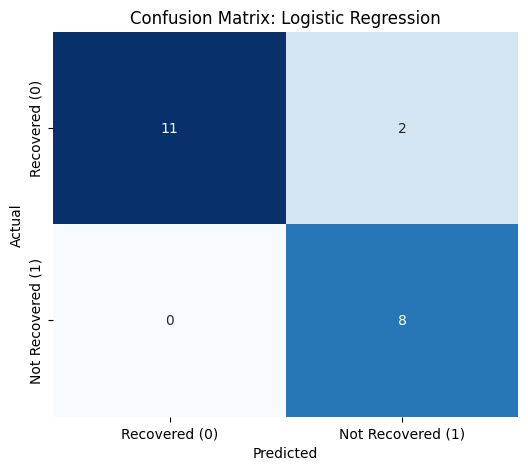

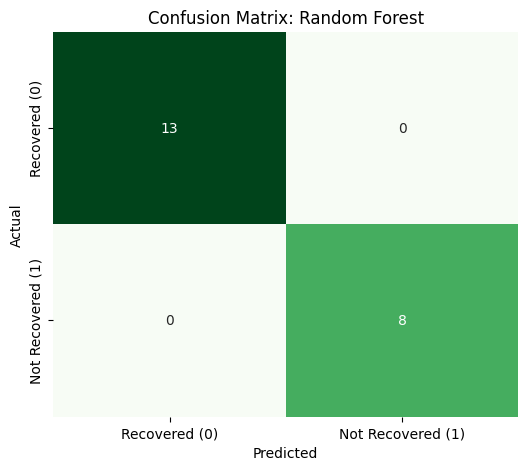

In [11]:
# --- Confusion Matrix for Logistic Regression ---
cm_lr = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Recovered (0)', 'Not Recovered (1)'],
            yticklabels=['Recovered (0)', 'Not Recovered (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

# --- Confusion Matrix for Random Forest ---
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Recovered (0)', 'Not Recovered (1)'],
            yticklabels=['Recovered (0)', 'Not Recovered (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest')
plt.show()

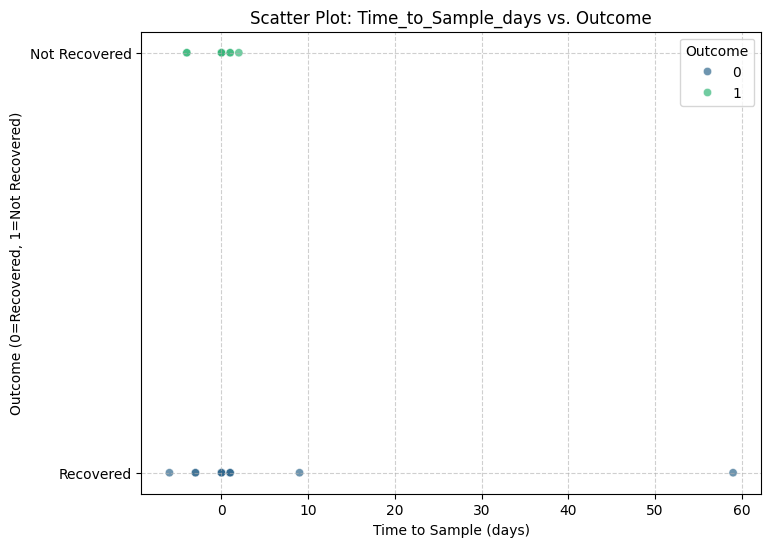

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Time_to_Sample_days', y='Outcome', data=df, hue='Outcome', palette='viridis', alpha=0.7)
plt.title('Scatter Plot: Time_to_Sample_days vs. Outcome')
plt.xlabel('Time to Sample (days)')
plt.ylabel('Outcome (0=Recovered, 1=Not Recovered)')
plt.yticks([0, 1], ['Recovered', 'Not Recovered'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Comparison of Feature Importance: Logistic Regression vs. Random Forest

In [14]:
print("Top 10 Feature Importances for Logistic Regression (by absolute coefficient):")
display(feature_importance.head(10))

print("\nTop 10 Feature Importances for Random Forest (by Gini importance):")
display(feature_importances_rf.head(10))

Top 10 Feature Importances for Logistic Regression (by absolute coefficient):


,Feature,Coefficient,Absolute_Coefficient
2,Ventilated (Y/N),1.237829,1.237829
22,"What kind of Treatment provided_antibiotics, O2",1.047632,1.047632
0,Patient Age,0.958960,0.958960
6,Platelet Count,-0.903349,0.903349
3,Red blood cell distribution width,0.714928,0.714928
19,"What kind of Treatment provided_Antibiotics, O2",-0.664677,0.664677
21,What kind of Treatment provided_antibiotics,0.540315,0.540315
8,Neutrophils Count,0.528170,0.528170
11,"What kind of Treatment provided_Antibiotics, O2",-0.369254,0.369254
28,Admission_Month_cos,0.323607,0.323607



Top 10 Feature Importances for Random Forest (by Gini importance):


,Feature,Importance
2,Ventilated (Y/N),0.222707
0,Patient Age,0.127605
3,Red blood cell distribution width,0.125814
6,Platelet Count,0.111934
22,"What kind of Treatment provided_antibiotics, O2",0.070194
7,Lymphocyte Count,0.043360
19,"What kind of Treatment provided_Antibiotics, O2",0.040351
5,White blood cell count,0.034162
8,Neutrophils Count,0.032761
32,Admission_Timestamp,0.029834


**Analysis of Feature Importance Comparison:**

Comparing the top features from both models reveals some interesting insights:

*   **Similarities at the Top**: Both models agree on the high importance of features like `Ventilated (Y/N)`, `Patient Age`, `Red blood cell distribution width`, and `Platelet Count`. This suggests these are robust predictors regardless of the model complexity.

*   **Differences in Ranking and Specific Features**: While `Ventilated (Y/N)` is consistently the most important, the exact ordering of other features can vary. For instance, `What kind of Treatment provided_antibiotics, O2` is very high for Logistic Regression, but slightly lower for Random Forest. Conversely, `Lymphocyte Count` appears earlier in the Random Forest list than in Logistic Regression.

*   **Date-related Features**:
    *   **Logistic Regression**: Features like `Admission_Month_sin`, `Admission_Month_cos`, and `Time_to_Sample_days` show noticeable absolute coefficients, indicating they contribute linearly (or through their linear transformation) to the prediction. `Admission_Year` shows 0 importance as expected.
    *   **Random Forest**: While `Admission_Timestamp` and `Sample_Collection_Timestamp` are present, their importance scores are lower compared to the top clinical features. This implies that while the models might use temporal information, for Random Forest, other features might capture more variance.

**Reasons for Differences:**

1.  **Model Nature**:
    *   **Logistic Regression** models linear relationships. Its coefficients directly reflect the log-odds change for a one-unit change in the feature. If a feature has a strong linear association with the outcome, it will have a high absolute coefficient.
    *   **Random Forest** is a tree-based ensemble model that can capture complex non-linear relationships and interactions between features. Its importance (Gini importance) measures how much a feature reduces impurity (or uncertainty) across all trees. A feature that interacts strongly with others but might not have a strong linear effect could still be very important to a Random Forest.
2.  **Redundancy**: If two features are highly correlated, a tree-based model might pick one over the other, distributing importance, while a linear model might assign coefficients to both. This is less likely to be a major factor here, as the top features are consistent.

In conclusion, the most critical features for predicting the outcome appear to be `Ventilated (Y/N)`, `Patient Age`, `Red blood cell distribution width`, and `Platelet Count` according to both models. The treatment type also plays a significant role. The date-related features contribute, but their relative importance varies depending on whether the model is looking for linear effects (Logistic Regression) or more complex interactions (Random Forest).